# Skin Cancer Detection Using Neural Networks

Vision and Cognitive Systems course 2023-2024 held by prof. L. Ballan

Oksana Abramova, Data Science, 2073541

Ekaterina Chueva, Physics of Data, 2072050

______



In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from torchvision.transforms import ToTensor, Normalize
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Mean, std for the dataset normalisation

In [ ]:
def get_mean_and_std(loader):
    mean=0.
    std=0.
    total_image_count = 0
    for images, _ in loader:

        image_count_in_a_batch = images.size(0)
        #print(images.shape)
        images = images.view(image_count_in_a_batch,images.size(1),-1)
        #print(images.shape)

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

        total_image_count += image_count_in_a_batch

    mean/= total_image_count
    std /=total_image_count

    return mean, std

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
train_dir = '/content/drive/MyDrive/Colab Notebooks/Train'

batch_size = 500
dataset = datasets.ImageFolder(train_dir, transform = data_transforms)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
mean, std = get_mean_and_std(loader)

In [ ]:
mean

tensor([0.7178, 0.5677, 0.5456])

In [ ]:
std

tensor([0.1222, 0.1333, 0.1443])

## Dataset upload and transformation

In [ ]:
class custom_subset(Dataset):

    def __init__(self, dataset, indices, labels):
        self.dataset = torch.utils.data.Subset(dataset, indices)
        self.targets = labels
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        target = self.targets[idx]
        return (image, target)

    def __len__(self):
        return len(self.targets)

In [ ]:
img_height, img_width = 224, 224
batch_size = 250

standard_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.7178, 0.5677, 0.5456], [0.1222, 0.1333, 0.1443])
])

aug_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(10),
    transforms.RandomResizedCrop(img_height, scale=(0.6, 0.6)),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue = 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.7178, 0.5677, 0.5456], [0.1222, 0.1333, 0.1443])
])

train_dir = '/content/drive/MyDrive/Colab Notebooks/Train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Test'

train_val_dataset = datasets.ImageFolder(train_dir, transform = aug_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform = standard_transforms)

validation_split = 0.2
shuffle_dataset = True
random_seed = 1234

dataset_size = len(train_val_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_subset_targets = [train_val_dataset.targets[i] for i in train_indices]
val_subset_targets = [train_val_dataset.targets[i] for i in val_indices]

#train and validation sets with shuffled data
train_subset = custom_subset(train_val_dataset, train_indices, train_subset_targets)
val_subset = custom_subset(train_val_dataset, val_indices, val_subset_targets)

#weights needed for oversampling underrepresented classes in train set
class_counts = Counter(train_subset.targets)
weights = [1/i for i in class_counts.values()]
samples_weights = np.array([weights[t] for t in train_subset.targets])
samples_weights = torch.from_numpy(samples_weights)

#weighted sampler
train_sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_val_dataset.classes)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

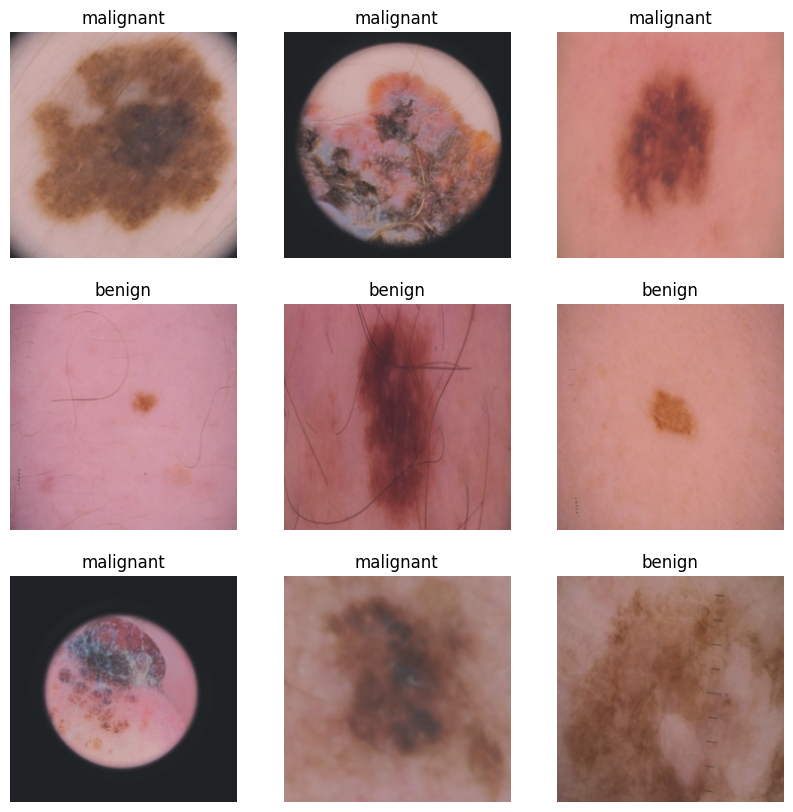

In [ ]:
def plot_images(data_loader, class_names):
  images, labels = next(iter(data_loader))
  plt.figure(figsize=(10,10))
  for i in range(9):
    plt.subplot(3,3,i+1)
    img = images[i].permute(1,2,0).numpy()
    img = img * np.array([0.7178, 0.5677, 0.5456]) + np.array([0.1222, 0.1333, 0.1443])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis('off')
  plt.show()


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
train_dir = '/content/drive/MyDrive/Colab Notebooks/Train'

dataset = datasets.ImageFolder(train_dir, transform = data_transforms)
loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
class_names = train_val_dataset.classes
plot_images(loader, class_names)

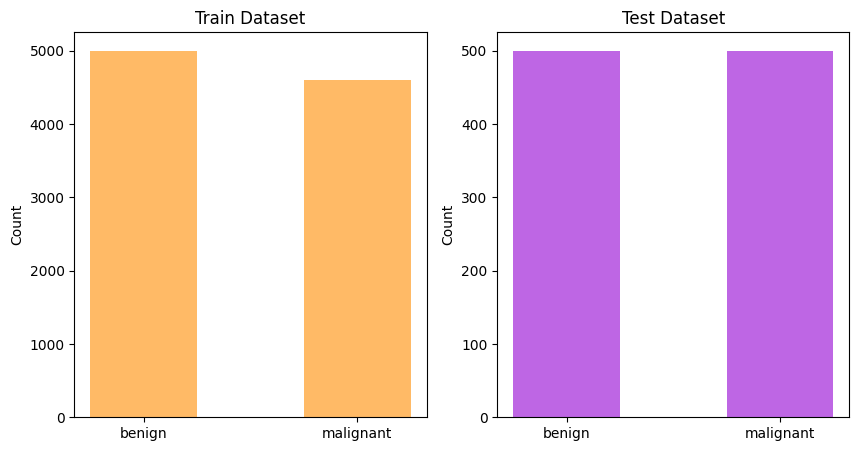

In [ ]:
class_counts = Counter(train_val_dataset.targets)
class_counts_test = Counter(test_dataset.targets)
class_names = train_val_dataset.classes
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.bar(class_names, class_counts.values(), width=0.5, color='darkorange', alpha=0.6)
plt.title('Train Dataset')
plt.ylabel('Count')
#plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(class_names, class_counts_test.values(), width=0.5, color='darkviolet', alpha=0.6)
plt.title('Test Dataset')
plt.ylabel('Count')
#plt.xticks(rotation=30, ha='right')

plt.show()

In [ ]:
def train_model(model, train_loader, validation_loader, num_epochs, lr=0.001, gamma = 0.1, momentum=0.9):
  criterion = nn.CrossEntropyLoss()
  #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
  scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5) #ExponentialLR

  train_loss_for_plot = []
  val_loss_for_plot = []

  #num_epochs = 30
  for epoch in range(num_epochs):
    model.train()
    r_loss = 0.0
    r_loss_val = 0.0

    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      r_loss += loss.item()

    scheduler.step(r_loss)
  #calculating validation loss
    with torch.no_grad():
      for inputs_val, labels_val in validation_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

        outputs_val = model(inputs_val)
        loss_val = criterion(outputs_val, labels_val)

        r_loss_val += loss_val.item()
    train_loss = r_loss/len(train_loader)
    val_loss = r_loss_val/len(validation_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Train loss: {train_loss}, Validation loss: {val_loss}')
    train_loss_for_plot.append(train_loss)
    val_loss_for_plot.append(val_loss)

  return model, train_loss_for_plot, val_loss_for_plot

In [ ]:
def evaluate_model(model, test_loader):
  model.eval()
  all_pred = []
  all_labels = []

  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      _, pred = torch.max(outputs, 1)
      all_pred.extend(pred.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  return np.array(all_labels), np.array(all_pred)

In [ ]:
def plot_learning_curves(model, train_loss_for_plot, val_loss_for_plot):
  plt.plot(train_loss_for_plot, label='Training Loss', c='darkgreen')
  plt.plot(val_loss_for_plot, label='Validaton loss', c='darkred')
  plt.title(model)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

## Baseline CNN

In [19]:
class BaselineCNN(nn.Module):
  def __init__(self, num_classes):
    super(BaselineCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    self.fc1 = nn.Linear(in_features=128*28*28, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

    self.drop = nn.Dropout(p=0.5)


  def forward(self, x):
    x = self.pool(torch.relu(self.conv1(x)))
    x = self.pool(torch.relu(self.conv2(x)))
    x = self.pool(torch.relu(self.conv3(x)))
    x = x.view(-1, 128*28*28)

    x = torch.relu(self.fc1(x))
    x = self.drop(x)
    x = self.fc2(x)

    return x


In [20]:
baseline_m = BaselineCNN(2).to(device)

In [21]:
base_m, train_l_for_plot, val_l_for_plot = train_model(baseline_m, train_loader, validation_loader, 10)

Epoch 1/10, Train loss: 1.5937318003946734, Validation loss: 0.36839526519179344
Epoch 2/10, Train loss: 0.3470933100869579, Validation loss: 0.31566284596920013
Epoch 3/10, Train loss: 0.31332426109621603, Validation loss: 0.2914885953068733
Epoch 4/10, Train loss: 0.2997627354437305, Validation loss: 0.27832750976085663
Epoch 5/10, Train loss: 0.29266388089426104, Validation loss: 0.29419156536459923
Epoch 6/10, Train loss: 0.30158599249778256, Validation loss: 0.2646952997893095
Epoch 7/10, Train loss: 0.282224892608581, Validation loss: 0.258926622569561
Epoch 8/10, Train loss: 0.2593167020428565, Validation loss: 0.25608942098915577
Epoch 9/10, Train loss: 0.25527191690860257, Validation loss: 0.2682203035801649
Epoch 10/10, Train loss: 0.2527141397999179, Validation loss: 0.25455151312053204


In [22]:
true_labels, predics = evaluate_model(base_m, test_loader)
accuracy = accuracy_score(true_labels, predics)

print(classification_report(true_labels, predics, target_names=train_val_dataset.classes))
print(f'Accuracy: {accuracy}')

f1 = f1_score(true_labels, predics, average='weighted')
print(f'F1 score: {f1}')

              precision    recall  f1-score   support

      benign       0.92      0.84      0.88       500
   malignant       0.86      0.93      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.88      1000
weighted avg       0.89      0.89      0.88      1000

Accuracy: 0.885
F1 score: 0.8848063594903033


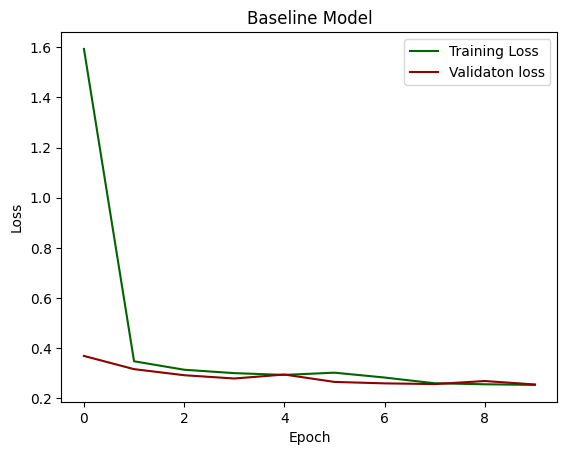

In [23]:
plot_learning_curves('Baseline Model', train_l_for_plot, val_l_for_plot)

## Resnet18

In [ ]:
resnet18 = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
for param in resnet18.parameters():
  param.requires_grad = False
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes) #the only one learnable layer

resnet18 = resnet18.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


In [ ]:
resnet18, train_loss_for_plot1, val_loss_for_plot1 = train_model(resnet18, train_loader, validation_loader, 10)

Epoch 1/10, Train loss: 0.5019066110253334, Validation loss: 0.368421345949173
Epoch 2/10, Train loss: 0.3394135572016239, Validation loss: 0.30901986360549927
Epoch 3/10, Train loss: 0.3109194841235876, Validation loss: 0.278451606631279
Epoch 4/10, Train loss: 0.3025832585990429, Validation loss: 0.28473393619060516
Epoch 5/10, Train loss: 0.29704013280570507, Validation loss: 0.26902085915207863
Epoch 6/10, Train loss: 0.27337545435875654, Validation loss: 0.265283465385437
Epoch 7/10, Train loss: 0.2740713516250253, Validation loss: 0.24974721670150757
Epoch 8/10, Train loss: 0.2674583178013563, Validation loss: 0.25395988300442696
Epoch 9/10, Train loss: 0.2628429904580116, Validation loss: 0.24157994240522385
Epoch 10/10, Train loss: 0.2678159885108471, Validation loss: 0.25261447951197624


In [ ]:
true_labels, predics = evaluate_model(resnet18, test_loader)
accuracy = accuracy_score(true_labels, predics)

print(classification_report(true_labels, predics, target_names=train_val_dataset.classes))
print(f'Accuracy: {accuracy}')

f1 = f1_score(true_labels, predics, average='weighted')
print(f'F1 score: {f1}')

              precision    recall  f1-score   support

      benign       0.91      0.89      0.90       500
   malignant       0.89      0.91      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

Accuracy: 0.898
F1 score: 0.897989798979898


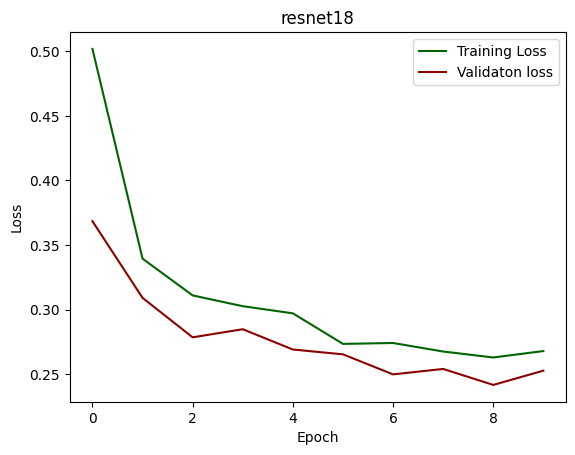

In [ ]:
plot_learning_curves('resnet18', train_loss_for_plot1, val_loss_for_plot1)

#### Resnet18 with additional layers and batchnorm

In [ ]:
resnet18_add = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
for param in resnet18_add.parameters():
  param.requires_grad = False

resnet18_add.fc = nn.Sequential(nn.Linear(resnet18_add.fc.in_features, 128),
                         nn.BatchNorm1d(128),
                         nn.ReLU(),
                         nn.Linear(128, num_classes))

resnet18_add = resnet18_add.to(device)

In [ ]:
resnet18_add, train_loss_for_plot2, val_loss_for_plot2 = train_model(resnet18_add, train_loader, validation_loader, 10)

Epoch 1/10, Train loss: 0.35042065382003784, Validation loss: 0.26486146822571754
Epoch 2/10, Train loss: 0.25155426375567913, Validation loss: 0.23158877715468407
Epoch 3/10, Train loss: 0.23474271409213543, Validation loss: 0.22259628027677536
Epoch 4/10, Train loss: 0.21826805360615253, Validation loss: 0.2143491692841053
Epoch 5/10, Train loss: 0.20430401992052794, Validation loss: 0.21839821711182594
Epoch 6/10, Train loss: 0.1982680531218648, Validation loss: 0.21172479167580605
Epoch 7/10, Train loss: 0.18373873084783554, Validation loss: 0.19820699095726013
Epoch 8/10, Train loss: 0.18648823350667953, Validation loss: 0.208281010389328
Epoch 9/10, Train loss: 0.18423979822546244, Validation loss: 0.20627523958683014
Epoch 10/10, Train loss: 0.17180749168619514, Validation loss: 0.20843220129609108


In [ ]:
true_labels, predics = evaluate_model(resnet18_add, test_loader)
accuracy = accuracy_score(true_labels, predics)

print(classification_report(true_labels, predics, target_names=train_val_dataset.classes))
print(f'Accuracy: {accuracy}')

f1 = f1_score(true_labels, predics, average='weighted')
print(f'F1 score: {f1}')

              precision    recall  f1-score   support

      benign       0.87      0.99      0.92       500
   malignant       0.99      0.85      0.91       500

    accuracy                           0.92      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.92      0.92      1000

Accuracy: 0.917
F1 score: 0.9165794771442843


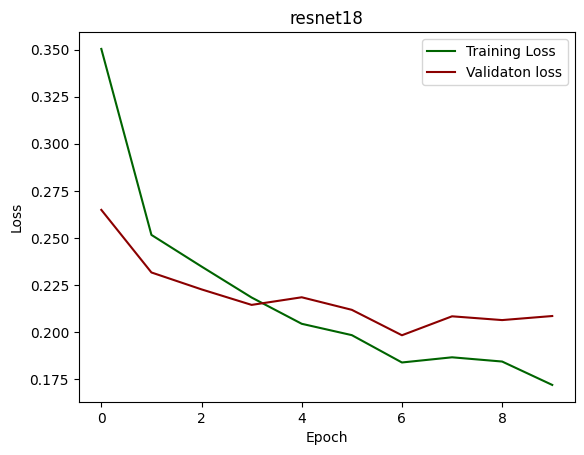

In [ ]:
plot_learning_curves('resnet18', train_loss_for_plot2, val_loss_for_plot2)

## Resnet50

In [ ]:
resnet50 = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
for param in resnet50.parameters():
  param.requires_grad = False
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

resnet50 = resnet50.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


In [ ]:
resnet50, train_loss_for_plot3, val_loss_for_plot3 = train_model(resnet50, train_loader, validation_loader, 10)

Epoch 1/10, Train loss: 0.5838801898062229, Validation loss: 0.42099349945783615
Epoch 2/10, Train loss: 0.37430914863944054, Validation loss: 0.32726509124040604
Epoch 3/10, Train loss: 0.31181525252759457, Validation loss: 0.29573608934879303
Epoch 4/10, Train loss: 0.298651821911335, Validation loss: 0.2765498608350754
Epoch 5/10, Train loss: 0.27428459469228983, Validation loss: 0.26513515412807465
Epoch 6/10, Train loss: 0.2670141337439418, Validation loss: 0.2602864168584347
Epoch 7/10, Train loss: 0.26495898701250553, Validation loss: 0.25144437327980995
Epoch 8/10, Train loss: 0.2682608375325799, Validation loss: 0.2531870938837528
Epoch 9/10, Train loss: 0.26558655966073275, Validation loss: 0.2502734586596489
Epoch 10/10, Train loss: 0.2587543074041605, Validation loss: 0.24744044244289398


In [ ]:
true_labels, predics = evaluate_model(resnet50, test_loader)
accuracy = accuracy_score(true_labels, predics)


print(classification_report(true_labels, predics, target_names=train_val_dataset.classes))
print(f'Accuracy: {accuracy}')

f1 = f1_score(true_labels, predics, average='weighted')
print(f'F1 score: {f1}')

              precision    recall  f1-score   support

      benign       0.90      0.87      0.89       500
   malignant       0.88      0.91      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

Accuracy: 0.891
F1 score: 0.8909684898935792


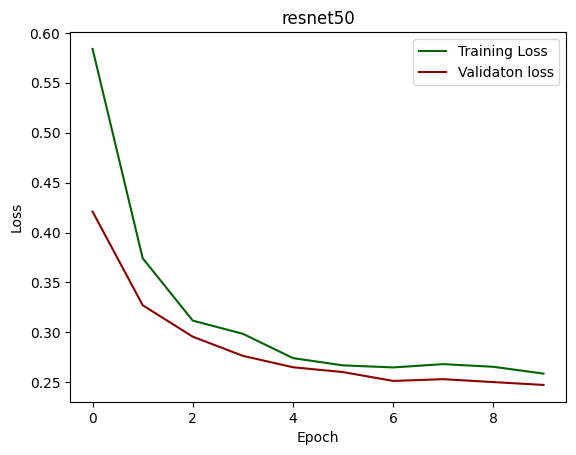

In [ ]:
plot_learning_curves('resnet50', train_loss_for_plot3, val_loss_for_plot3)

#### Resnet50 with additional layers and batchnorm

In [ ]:
resnet50_add = models.resnet50(weights='ResNet50_Weights.DEFAULT')
for param in resnet50_add.parameters():
  param.requires_grad = False

resnet50_add.fc = nn.Sequential(nn.BatchNorm1d(resnet50_add.fc.in_features),
                         nn.Linear(resnet50_add.fc.in_features,64),
                         nn.ReLU(),
                         nn.Linear(64, num_classes))

resnet50_add = resnet50_add.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


In [ ]:
resnet50_add, train_loss_for_plot4, val_loss_for_plot4 = train_model(resnet50_add, train_loader, validation_loader, 10)

Epoch 1/10, Train loss: 0.34649848751723766, Validation loss: 0.26056021079421043
Epoch 2/10, Train loss: 0.23503176774829626, Validation loss: 0.21484286338090897
Epoch 3/10, Train loss: 0.21882527973502874, Validation loss: 0.20962659269571304
Epoch 4/10, Train loss: 0.1974367443472147, Validation loss: 0.2127416729927063
Epoch 5/10, Train loss: 0.18538332637399435, Validation loss: 0.21315120160579681
Epoch 6/10, Train loss: 0.1755498293787241, Validation loss: 0.19890481606125832
Epoch 7/10, Train loss: 0.1665199249982834, Validation loss: 0.1925499103963375
Epoch 8/10, Train loss: 0.16474363207817078, Validation loss: 0.20261844247579575
Epoch 9/10, Train loss: 0.14960139524191618, Validation loss: 0.21002941206097603
Epoch 10/10, Train loss: 0.1451443242840469, Validation loss: 0.1937059797346592


In [ ]:
true_labels, predics = evaluate_model(resnet50_add, test_loader)
accuracy = accuracy_score(true_labels, predics)

print(classification_report(true_labels, predics, target_names=train_val_dataset.classes))
print(f'Accuracy: {accuracy}')

f1 = f1_score(true_labels, predics, average='weighted')
print(f'F1 score: {f1}')

              precision    recall  f1-score   support

      benign       0.90      0.93      0.92       500
   malignant       0.93      0.90      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

Accuracy: 0.917
F1 score: 0.9169813207971795


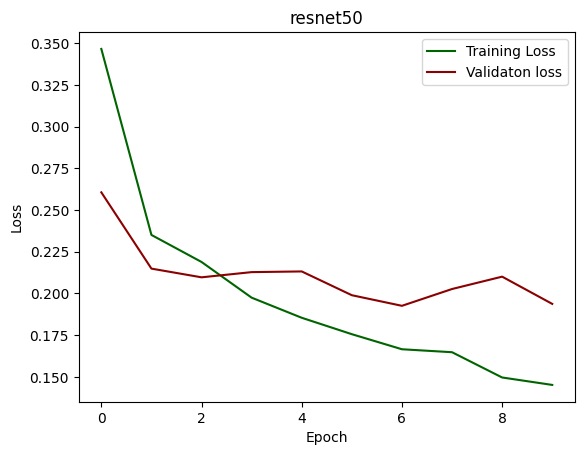

In [ ]:
plot_learning_curves('resnet50', train_loss_for_plot4, val_loss_for_plot4)

## Densenet

In [ ]:
densenet = models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1')

for param in densenet.parameters():
  param.requires_grad = False

densenet.classifier = nn.Sequential(nn.Linear(densenet.classifier.in_features, num_classes))

densenet = densenet.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 58.6MB/s]


In [ ]:
densenet, train_loss_for_plot5, val_loss_for_plot5 = train_model(densenet, train_loader, validation_loader, 10)

Epoch 1/10, Train loss: 0.5168898217380047, Validation loss: 0.369977205991745
Epoch 2/10, Train loss: 0.33969772420823574, Validation loss: 0.29149148613214493
Epoch 3/10, Train loss: 0.29290971159935, Validation loss: 0.2749060019850731
Epoch 4/10, Train loss: 0.28261668514460325, Validation loss: 0.2778182178735733
Epoch 5/10, Train loss: 0.2841764288023114, Validation loss: 0.2506350763142109
Epoch 6/10, Train loss: 0.2604090590029955, Validation loss: 0.24480221793055534
Epoch 7/10, Train loss: 0.26130920462310314, Validation loss: 0.2528620772063732
Epoch 8/10, Train loss: 0.2574591236189008, Validation loss: 0.2419414296746254
Epoch 9/10, Train loss: 0.26393798273056746, Validation loss: 0.23034269735217094
Epoch 10/10, Train loss: 0.24113588873296976, Validation loss: 0.24105485156178474


In [ ]:
true_labels, predics = evaluate_model(densenet, test_loader)
accuracy = accuracy_score(true_labels, predics)


print(classification_report(true_labels, predics, target_names=train_val_dataset.classes))
print(f'Accuracy: {accuracy}')

f1 = f1_score(true_labels, predics, average='weighted')
print(f'F1 score: {f1}')

              precision    recall  f1-score   support

      benign       0.89      0.92      0.90       500
   malignant       0.92      0.88      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

Accuracy: 0.902
F1 score: 0.9019525450317954


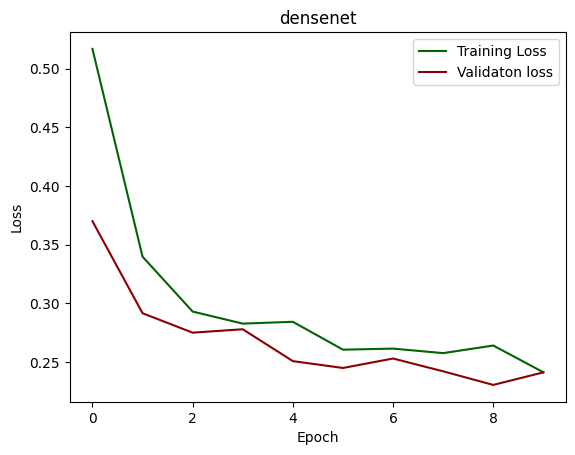

In [ ]:
plot_learning_curves('densenet', train_loss_for_plot5, val_loss_for_plot5)

#### Densenet + 4 layer MLP

In [ ]:
densenet_mlp = models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1')

for param in densenet_mlp.parameters():
  param.requires_grad = False

densenet_mlp.classifier = nn.Sequential(nn.Linear(densenet_mlp.classifier.in_features, 50),
                                        nn.BatchNorm1d(50),
                                        nn.ReLU(),
                                        nn.Linear(50, 200),
                                        nn.BatchNorm1d(200),
                                        nn.ReLU(),
                                        nn.Linear(200, 200),
                                        nn.BatchNorm1d(200),
                                        nn.ReLU(),
                                        nn.Linear(200, 100),
                                        nn.BatchNorm1d(100),
                                        nn.ReLU(),
                                        nn.Linear(100, num_classes)
                                        )

densenet_mlp = densenet_mlp.to(device)

In [ ]:
densenet_mlp, train_loss_for_plot6, val_loss_for_plot6 = train_model(densenet_mlp, train_loader, validation_loader, 10, 0.01)

Epoch 1/10, Train loss: 0.3403359539806843, Validation loss: 0.22415480762720108
Epoch 2/10, Train loss: 0.21407971810549498, Validation loss: 0.20554132014513016
Epoch 3/10, Train loss: 0.1969279022887349, Validation loss: 0.19997315481305122
Epoch 4/10, Train loss: 0.18774485494941473, Validation loss: 0.20229755714535713
Epoch 5/10, Train loss: 0.1690177619457245, Validation loss: 0.20141589269042015
Epoch 6/10, Train loss: 0.15237094182521105, Validation loss: 0.20241041481494904
Epoch 7/10, Train loss: 0.15020929602906108, Validation loss: 0.20171861350536346
Epoch 8/10, Train loss: 0.1639905422925949, Validation loss: 0.19911956414580345
Epoch 9/10, Train loss: 0.14448002353310585, Validation loss: 0.21089859679341316
Epoch 10/10, Train loss: 0.1397800170816481, Validation loss: 0.21391653642058372


In [ ]:
true_labels, predics = evaluate_model(densenet_mlp, test_loader)
accuracy = accuracy_score(true_labels, predics)

print(classification_report(true_labels, predics, target_names=train_val_dataset.classes))
print(f'Accuracy: {accuracy}')

f1 = f1_score(true_labels, predics, average='weighted')
print(f'F1 score: {f1}')

              precision    recall  f1-score   support

      benign       0.89      0.94      0.91       500
   malignant       0.93      0.89      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

Accuracy: 0.913
F1 score: 0.9129539526409471


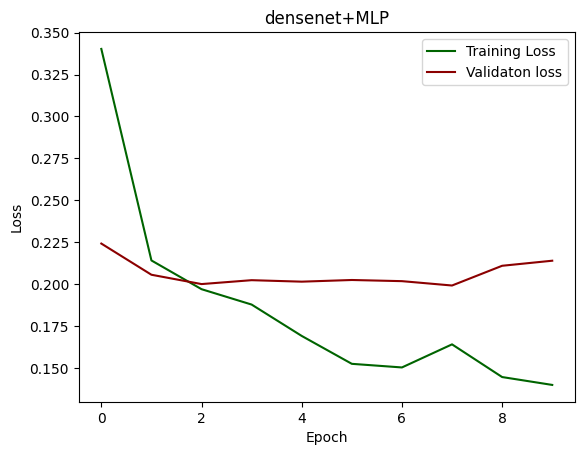

In [ ]:
plot_learning_curves('densenet+MLP', train_loss_for_plot6, val_loss_for_plot6)

## Attention Mechanism

In [24]:
class ImprovedAttCNN(nn.Module):
  def __init__(self, num_classes):
    super(ImprovedAttCNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d(256)

    self.pool = nn.MaxPool2d(2, 2)
    self.attention = nn.Sequential(
        nn.Conv2d(256, 128, kernel_size=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=1),
        nn.Sigmoid()
    )

    self.fc1 = nn.Linear(256 * 14 * 14, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, num_classes)

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))
    x = self.pool(F.relu(self.bn4(self.conv4(x))))

    atten_weights = self.attention(x)
    x = x * atten_weights

    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)

    return x

In [25]:
attent_model = ImprovedAttCNN(num_classes = 2).to(device)

In [26]:
attent_mech, train_loss_for_plot8, val_loss_for_plot8 = train_model(attent_model, train_loader, validation_loader, 10)

Epoch 1/10, Train loss: 1.742629595341221, Validation loss: 0.42731885612010956
Epoch 2/10, Train loss: 0.4110009160733992, Validation loss: 0.3296414762735367
Epoch 3/10, Train loss: 0.3414870375587094, Validation loss: 0.32185351103544235
Epoch 4/10, Train loss: 0.32035843018562565, Validation loss: 0.29645946621894836
Epoch 5/10, Train loss: 0.317473140935744, Validation loss: 0.27059818617999554
Epoch 6/10, Train loss: 0.29957833405463924, Validation loss: 0.2616967987269163
Epoch 7/10, Train loss: 0.282570305851198, Validation loss: 0.26033445075154305
Epoch 8/10, Train loss: 0.2765118816206532, Validation loss: 0.2482313048094511
Epoch 9/10, Train loss: 0.26588152060585635, Validation loss: 0.26990167051553726
Epoch 10/10, Train loss: 0.27442195098246297, Validation loss: 0.23305470496416092


In [27]:
true_labels, predics = evaluate_model(attent_mech, test_loader)
accuracy = accuracy_score(true_labels, predics)

print(classification_report(true_labels, predics, target_names=train_val_dataset.classes))
print(f'Accuracy: {accuracy}')
f1 = f1_score(true_labels, predics, average='weighted')
print(f'F1 score: {f1}')

              precision    recall  f1-score   support

      benign       0.89      0.94      0.91       500
   malignant       0.94      0.88      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

Accuracy: 0.911
F1 score: 0.9109250879990073


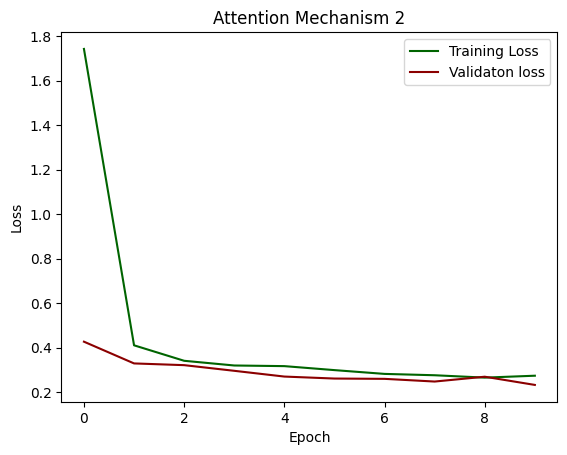

In [28]:
plot_learning_curves('Attention Mechanism 2', train_loss_for_plot8, val_loss_for_plot8)